In [27]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

In [71]:
# set up simulation constants

resolution = 20

n_air = 1.0000003
n_siox = 1.45

a = 0.5   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_hole = 5
height_siox = 0.780
height_space = 0.3

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + height_siox + height_hole+height_space, 3)

z_air = height_space

center_siox = round(pml_thickness + 0.5*height_siox - 0.5*cell_z, 3)
center_hole = round(pml_thickness + height_siox + 0.5*height_hole
                    - 0.5*cell_z, 3) 
center_air = round(pml_thickness + height_siox+height_hole+0.5*z_air- 0.5*cell_z, 3)

#z_siox = pml_thickness + height_siox +height_space


In [72]:

geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_air), 
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air))]
            
k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 30 # this is the number of pillars we will build
data = np.zeros((3,num))

## set up and build source ##
############################

center_source = round(pml_thickness + height_siox*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


In [78]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]

geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,cell_z),
                    center=mp.Vector3(0,0,center_hole),
                    material=mp.Medium(index=n_siox)),
           mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_air),
                   center=mp.Vector3(0,0,center_air),
                   material=mp.Medium(index=n_air))]

sim = mp.Simulation(cell_size=cell_size,
                    #geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.5*height_space, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)
min = 0.0
max = 0.24

print (geometry)

[<meep.geom.Block object at 0x7f8ad5f4d250>, <meep.geom.Block object at 0x7f8ad7893a90>]


In [79]:
sim.run(until=200)

initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
sim.reset_meep()

pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(min,max,num=num)):

    geometry.append(mp.Cylinder(radius=radius,
                        height=height_hole,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_hole),
                        material=mp.Medium(index=n_air)))
                                
    #geometry=mp.Cylinder(radius=radius,


    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)

    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase

    
    if(radius!=max):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00099206 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
time for set_epsilon = 0.0129559 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000928164 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.037641 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


  3%|█████▊                                                                                                                                                                         | 1/30 [00:01<00:34,  1.19s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 0,radius=0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000886917 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.00827586, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0384691 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


  7%|███████████▋                                                                                                                                                                   | 2/30 [00:02<00:33,  1.21s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 1,radius=0.008275862068965517
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00078702 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0165517, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0389111 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 10%|█████████████████▌                                                                                                                                                             | 3/30 [00:03<00:32,  1.20s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 2,radius=0.016551724137931035
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0010891 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0248276, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0398822 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:04<00:31,  1.21s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 3,radius=0.024827586206896554
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000806808 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0331034, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0546319 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:06<00:30,  1.20s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 4,radius=0.03310344827586207
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00074482 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0413793, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.075779 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:07<00:29,  1.24s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 5,radius=0.041379310344827586
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000702858 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0496552, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.082171 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:08<00:29,  1.27s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 6,radius=0.04965517241379311
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00100493 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.057931, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.104636 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 27%|██████████████████████████████████████████████▋                                                                                                                                | 8/30 [00:09<00:28,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 7,radius=0.057931034482758624
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000761032 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0662069, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0859191 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:11<00:26,  1.28s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 8,radius=0.06620689655172414
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0013001 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0744828, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.088372 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:12<00:25,  1.28s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 9,radius=0.07448275862068966
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000960827 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0827586, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0925422 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:13<00:24,  1.28s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 10,radius=0.08275862068965517
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000802994 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0910345, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.105626 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 12/30 [00:15<00:23,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 11,radius=0.0910344827586207
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000672102 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.0993103, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0903769 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 13/30 [00:16<00:21,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 12,radius=0.09931034482758622
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000919819 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.107586, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.094835 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 14/30 [00:17<00:20,  1.28s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 13,radius=0.10758620689655173
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00114298 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.115862, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0881851 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 15/30 [00:18<00:19,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 14,radius=0.11586206896551725
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00120401 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.124138, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.071121 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:20<00:17,  1.27s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 15,radius=0.12413793103448276
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00110793 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.132414, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.112051 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 17/30 [00:21<00:16,  1.26s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 16,radius=0.13241379310344828
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.001086 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.14069, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.113523 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18/30 [00:22<00:15,  1.26s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 17,radius=0.1406896551724138
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00126696 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.148966, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.099813 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19/30 [00:24<00:14,  1.27s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 18,radius=0.14896551724137932
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00119591 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.157241, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.1033 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:25<00:12,  1.28s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 19,radius=0.15724137931034482
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000764847 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.165517, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.10157 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 21/30 [00:26<00:11,  1.26s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 20,radius=0.16551724137931034
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00105214 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.173793, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.095885 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:27<00:10,  1.27s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 21,radius=0.17379310344827587
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00138593 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.182069, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.103547 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 23/30 [00:29<00:08,  1.26s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 22,radius=0.1820689655172414
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000822067 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.190345, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0917301 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 24/30 [00:30<00:07,  1.27s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 23,radius=0.1903448275862069
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0011189 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.198621, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.111727 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25/30 [00:31<00:06,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 24,radius=0.19862068965517243
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00119209 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.206897, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.135648 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26/30 [00:32<00:05,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 25,radius=0.20689655172413793
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00123501 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.215172, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.113842 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27/30 [00:34<00:03,  1.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 26,radius=0.21517241379310345
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000743151 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.223448, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.132098 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [00:35<00:02,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 27,radius=0.22344827586206897
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000898123 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.231724, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.120222 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29/30 [00:36<00:01,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 28,radius=0.2317241379310345
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00101995 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.24, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.092869 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


     block, center = (0,0,0.24)
          size (1e+20,1e+20,7.64)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,2.89)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.24)
          radius 0.24, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


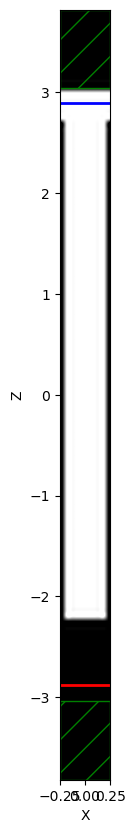

In [80]:
# plot an x-z cross section

plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

In [81]:
len(data[1])

30

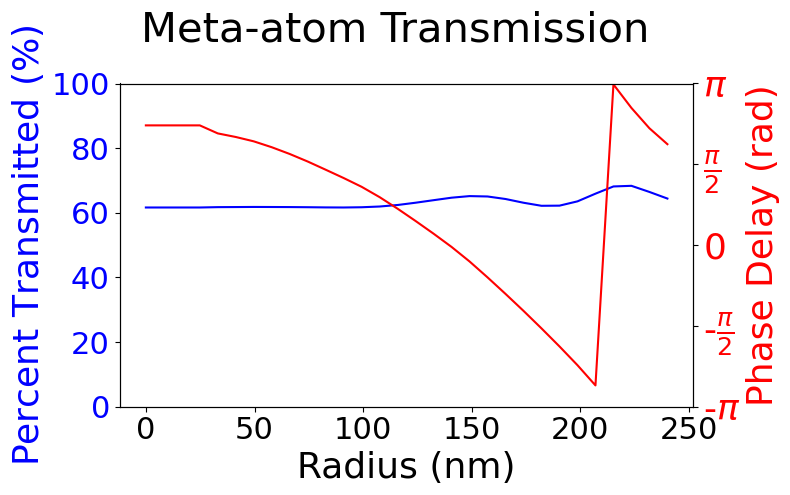

In [82]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phas and transmission

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
#ax.plot(radii,flux_list,'b',label='Transmission')
ax.plot(radii, flux_list, 'b', label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels([60,70,80,90,100],fontsize=tickfontsize)

twin1 = ax.twinx()ight_space, 3)

z_air = height_space

center_siox = round(0.5*(pml_thickness + height_siox) - 0.5*cell_z, 3)
center_hole = round(pml_thickness + height_siox + 0.5*height_hole
                    - 0.5*cell_z, 3) 
center_air = round(0.5*(height_hole + height_space + pml_thickness) 
                    + (pml_thickness + height_siox) - 0.5*cell_z, 3)

#z_siox = pml_thickness + height_siox +height_space


#ax[1].set_title("Transmission Phase",fontsize=titlefontsize)S
#ax[1].set_xlabel("Radius (nm)",fontsize=labelfontsize)
#ax[1].set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])cd meep

#ax[1].set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()


